# Benchmark code inter-processo

In questo notebook si vogliono evidenziare prestazioni e possibili criticità
della coda utilizzata per la comunicazione interprocesso, ossia
`multiprocessing.Queue`.

La coda permette di implementare facilmente un paradigma _produttore-consumatore_
largamente usato per distribuire task a dei processi _worker_.

Essendo la comunicazione inter-processo, ogni oggetto inserito nella coda viene
serializzato e viene deserializzato nel momento in cui viene estratto. Il modulo
usato per serializzare i vari oggetti è `pickle`.

Il benchmark è molto semplice: verranno inseriti e rimossi vari oggetti, di
diverse dimensioni nella coda. Lo stesso oggetto verrà inserito (e rimosso) 100
volte al fine di avere un dato statistico solido. Saranno poi calcolati tempo
medio e deviazione standard dei tempi di inserimento e rimozione dalla coda.

Come oggetto da inviare utilizzeremo degli array `numpy`, i quali hanno una
dimensione ben definita, sia in termini di struttura, sia in termini di
attributi.


In [1]:
import numpy as np

a = np.array([i for i in range(10)])
print(f"numpy array size: {a.nbytes} bytes")

numpy array size: 80 bytes


Come ci si poteva aspettare, `numpy` inizializza vettori di valori a 8 byte
a meno che non si specifichi un tipo diverso.

Definiamo quindi la funzione che testa le prestazioni di inserimento e rimozione
in questo modo:


In [2]:
import multiprocessing as mp
import time
import matplotlib.pyplot as plt
import pickle

pickle.DEFAULT_PROTOCOL = pickle.HIGHEST_PROTOCOL


def benchmark(dim: int):
    q = mp.Queue()
    buffer = np.array([i for i in range(dim)])
    print(f"dimension: {dim}, bytes: {buffer.nbytes}")

    put_times = []
    get_times = []
    for _ in range(100):
        start = time.perf_counter()
        q.put(buffer)
        end_put = time.perf_counter()
        q.get()
        end = time.perf_counter()

        put_times.append(end_put - start)
        get_times.append(end - end_put)

    return np.mean(put_times), np.std(put_times), np.mean(get_times), np.std(get_times)


dims = np.around(np.geomspace(10, 5242880 * 2, 21)).astype(int)
dims

array([      10,       20,       40,       80,      160,      320,
            640,     1280,     2560,     5120,    10240,    20480,
          40960,    81920,   163840,   327680,   655360,  1310720,
        2621440,  5242880, 10485760])

Non rimane che effettuare i test su varie dimensioni.


In [3]:
put_means = []
put_stds = []
get_means = []
get_stds = []

for d in dims:
    put_mean, put_std, get_mean, get_std = benchmark(d)
    print(f" put: ({put_mean:.5f}, {put_std:.5f})")
    print(f" get: ({get_mean:.5f}, {get_std:.5f})")

    put_means.append(put_mean)
    put_stds.append(put_std)

    get_means.append(get_mean)
    get_stds.append(get_std)


dimension: 10, bytes: 80
 put: (0.00002, 0.00010)
 get: (0.00009, 0.00008)
dimension: 20, bytes: 160
 put: (0.00002, 0.00017)
 get: (0.00008, 0.00017)
dimension: 40, bytes: 320
 put: (0.00001, 0.00006)
 get: (0.00009, 0.00009)
dimension: 80, bytes: 640
 put: (0.00001, 0.00002)
 get: (0.00011, 0.00023)
dimension: 160, bytes: 1280
 put: (0.00003, 0.00018)
 get: (0.00008, 0.00014)
dimension: 320, bytes: 2560
 put: (0.00001, 0.00002)
 get: (0.00009, 0.00012)
dimension: 640, bytes: 5120
 put: (0.00010, 0.00039)
 get: (0.00039, 0.00083)
dimension: 1280, bytes: 10240
 put: (0.00004, 0.00025)
 get: (0.00014, 0.00033)
dimension: 2560, bytes: 20480
 put: (0.00004, 0.00027)
 get: (0.00008, 0.00003)
dimension: 5120, bytes: 40960
 put: (0.00001, 0.00005)
 get: (0.00010, 0.00010)
dimension: 10240, bytes: 81920
 put: (0.00001, 0.00002)
 get: (0.00013, 0.00005)
dimension: 20480, bytes: 163840
 put: (0.00001, 0.00002)
 get: (0.00017, 0.00012)
dimension: 40960, bytes: 327680
 put: (0.00001, 0.00004)
 ge

Abbiamo quindi esaminato una serie di possibili valori, da 80 byte a 40 MB.
Vediamo come si sviluppa il grafico.


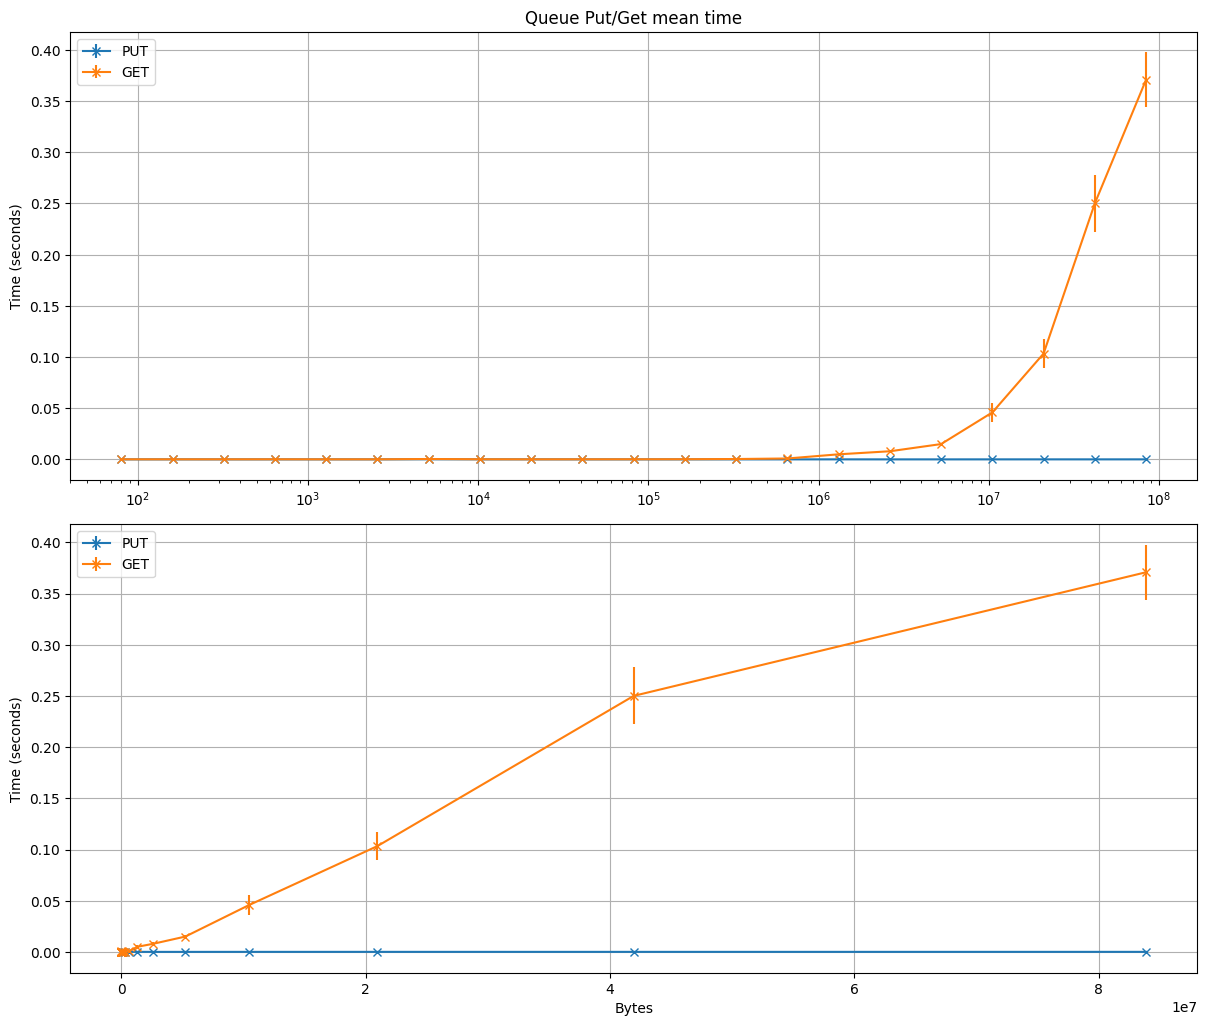

In [4]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
plt.tight_layout()

# plt.figure(figsize=(16, 9))
ax1.set_title("Queue Put/Get mean time")
# ax1.set_xlabel("Bytes")
ax1.set_ylabel("Time (seconds)")

ax1.errorbar(dims * 8, put_means, put_stds, marker="x", label="PUT")
ax1.errorbar(dims * 8, get_means, get_stds, marker="x", label="GET")

ax1.legend()
ax1.set_xscale("log")
ax1.grid()

ax2.set_xlabel("Bytes")
ax2.set_ylabel("Time (seconds)")

ax2.errorbar(dims * 8, put_means, put_stds, marker="x", label="PUT")
ax2.errorbar(dims * 8, get_means, get_stds, marker="x", label="GET")

ax2.legend()
ax2.set_xscale("linear")
ax2.grid()

plt.show()

Come possiamo notare dal grafico, il costo dell'operazione di `put` rimane
praticamente costante, mentre quello dell'operazione di `get` tende a crescere
in stabilmente con il crescere della quantità di byte inviati.

Di seguito una semplice regressione lineare per capire la pendenza di tale
curva.


coefficiente angolare: 4.7187952977771085e-09


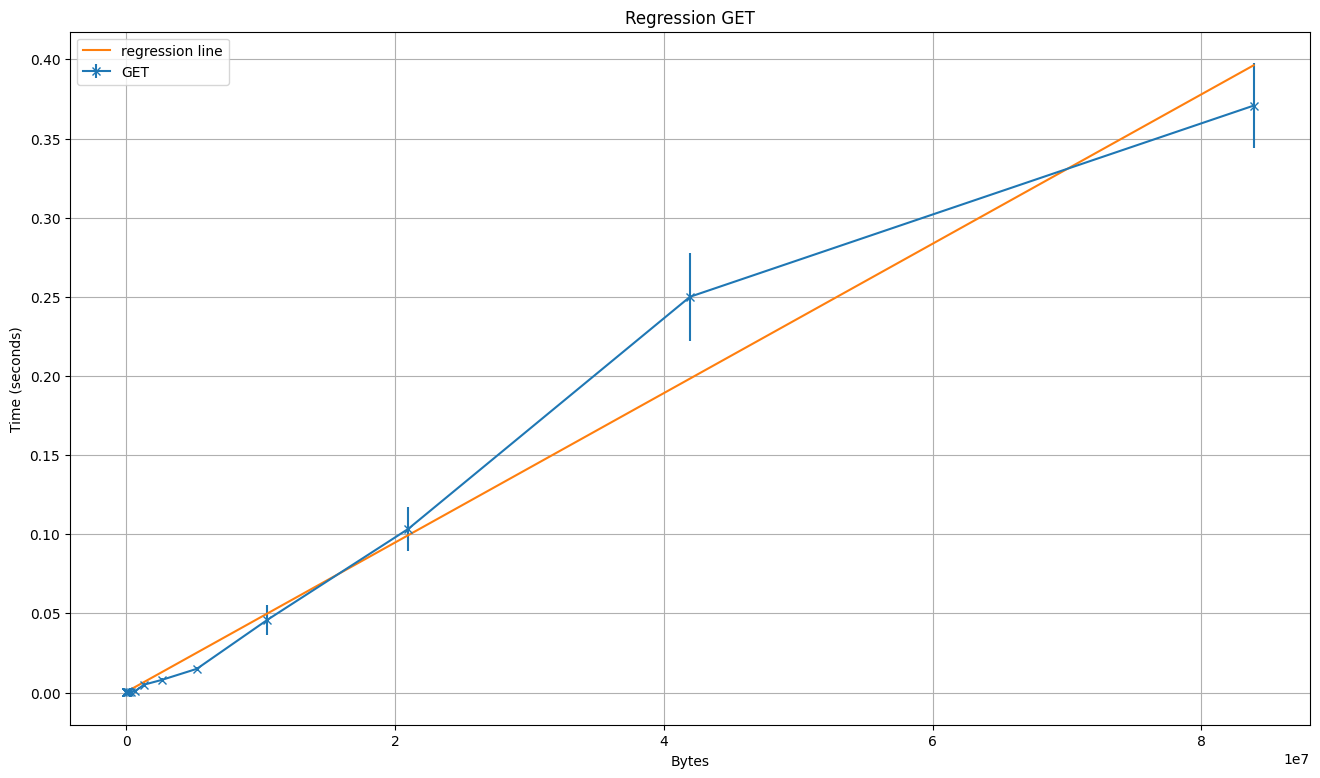

In [19]:
import statistics

slope, intercept = statistics.linear_regression(dims * 8, get_means)

print(f"coefficiente angolare: {slope}")

x = np.linspace(dims.min() * 8, dims.max() * 8, len(dims))
y = x * slope + intercept


plt.figure(figsize=(16, 9))
plt.title("Regression GET")
plt.xlabel("Bytes")
plt.ylabel("Time (seconds)")

plt.errorbar(dims * 8, get_means, get_stds, marker="x", label="GET")
plt.plot(x, y, label="regression line")

plt.legend()
plt.grid()
plt.show()

Come si può notare, il coefficiente angolare della retta di regressione è molto
basso. Ciò ci dice che il tempo dell'operazione di `get` cresce comunque molto
lentamente garantendo performance stabili anche per grandi quantità di dati.


In [44]:
import pandas as pd


df = pd.DataFrame(
    {
        "size (bytes)": dims * 8,
        "put_mean (ms)": np.asarray(put_means) * 1000.0,
        "put_std (ms)": np.asarray(put_stds) * 1000.0,
        "get_mean (ms)": np.asarray(get_means) * 1000.0,
        "get_stds (ms)": np.asarray(get_stds) * 1000.0,
        "byte/ms": (dims * 8) / (np.asarray(get_means) * 1000.0),
    }
)

df

,size (bytes),put_mean (ms),put_std (ms),get_mean (ms),get_stds (ms),byte/ms
0,80,0.017626,0.098975,0.090247,0.083832,886.452033
1,160,0.024325,0.173517,0.084472,0.168868,1894.108222
2,320,0.014885,0.064510,0.091407,0.089652,3500.827509
3,640,0.009761,0.023215,0.112792,0.227960,5674.182413
4,1280,0.026180,0.177347,0.081538,0.139605,15698.244430
5,2560,0.010866,0.022472,0.088617,0.122546,28888.508966
6,5120,0.097169,0.388960,0.392338,0.828292,13049.988849
7,10240,0.036210,0.254603,0.143826,0.333282,71197.017227
8,20480,0.035564,0.271464,0.084738,0.033933,241686.052989
9,40960,0.011996,0.048015,0.104800,0.098866,390840.813433


Come si può notare, per inviare 80 byte ci si impiega circa un decimo di
millisecondo. Questa breve e semplice analisi ci rivela comunque che se


In [5]:
def benchmark_pickle(dim: int):
    buffer = np.array([i for i in range(dim)])
    print(f"dimension: {dim}, bytes: {buffer.nbytes}")

    dump_times = []
    load_times = []
    for _ in range(100):
        start = time.perf_counter()
        data = pickle.dumps(buffer)
        end_put = time.perf_counter()
        pickle.loads(data)
        end = time.perf_counter()

        dump_times.append(end_put - start)
        load_times.append(end - end_put)

    return (
        np.mean(dump_times),
        np.std(dump_times),
        np.mean(load_times),
        np.std(load_times),
    )

In [6]:
dump_means = []
dump_stds = []
load_means = []
load_stds = []

for d in dims:
    dump_mean, dump_std, load_mean, load_std = benchmark_pickle(d)
    print(f" dump: ({dump_mean:.5f}, {dump_std:.5f})")
    print(f" load: ({load_mean:.5f}, {load_std:.5f})")

    dump_means.append(dump_mean)
    dump_stds.append(dump_std)

    load_means.append(load_mean)
    load_stds.append(load_std)


dimension: 10, bytes: 80
 dump: (0.00001, 0.00001)
 load: (0.00001, 0.00001)
dimension: 20, bytes: 160
 dump: (0.00002, 0.00010)
 load: (0.00001, 0.00001)
dimension: 40, bytes: 320
 dump: (0.00001, 0.00000)
 load: (0.00001, 0.00000)
dimension: 80, bytes: 640
 dump: (0.00001, 0.00001)
 load: (0.00001, 0.00001)
dimension: 160, bytes: 1280
 dump: (0.00001, 0.00004)
 load: (0.00001, 0.00001)
dimension: 320, bytes: 2560
 dump: (0.00002, 0.00002)
 load: (0.00001, 0.00001)
dimension: 640, bytes: 5120
 dump: (0.00001, 0.00001)
 load: (0.00001, 0.00001)
dimension: 1280, bytes: 10240
 dump: (0.00002, 0.00006)
 load: (0.00001, 0.00000)
dimension: 2560, bytes: 20480
 dump: (0.00001, 0.00001)
 load: (0.00001, 0.00001)
dimension: 5120, bytes: 40960
 dump: (0.00001, 0.00001)
 load: (0.00001, 0.00000)
dimension: 10240, bytes: 81920
 dump: (0.00003, 0.00004)
 load: (0.00002, 0.00004)
dimension: 20480, bytes: 163840
 dump: (0.00003, 0.00003)
 load: (0.00002, 0.00001)
dimension: 40960, bytes: 327680
 dum

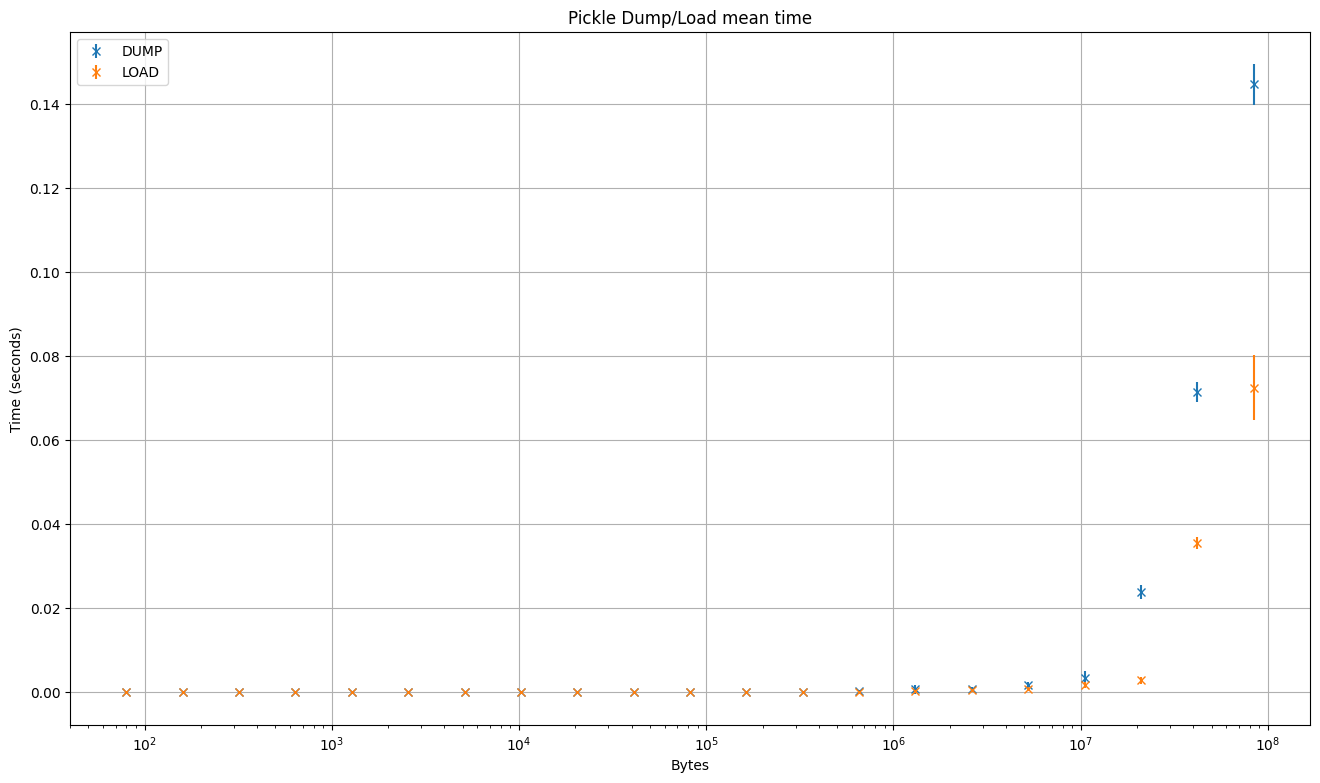

In [7]:
plt.figure(figsize=(16, 9))
plt.title("Pickle Dump/Load mean time")
plt.xlabel("Bytes")
plt.ylabel("Time (seconds)")

plt.errorbar(
    dims * 8, dump_means, dump_stds, linestyle="None", marker="x", label="DUMP"
)
plt.errorbar(
    dims * 8, load_means, load_stds, linestyle="None", marker="x", label="LOAD"
)

plt.legend()
plt.xscale("log")
plt.grid()
plt.show()

In [8]:
data = pickle.dumps(1)
pickle.loads(data)

1

Analisi per parallelismo
